Logistic Regression: Hand Calculation Visualization


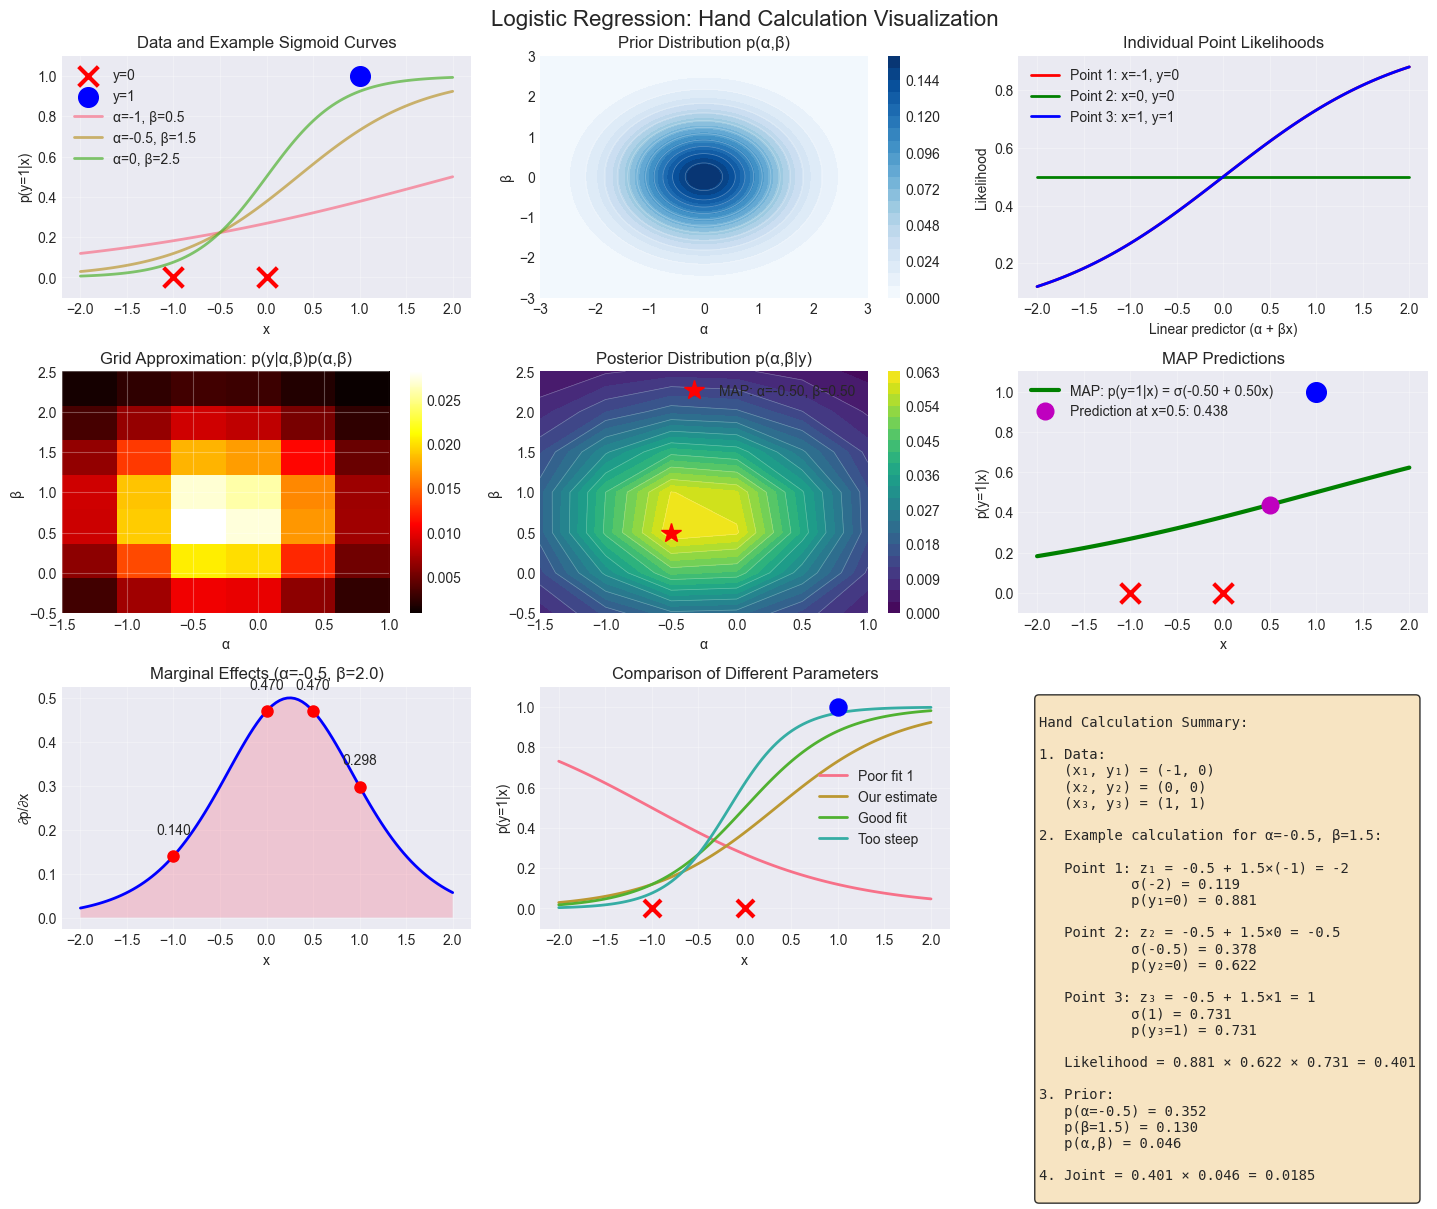

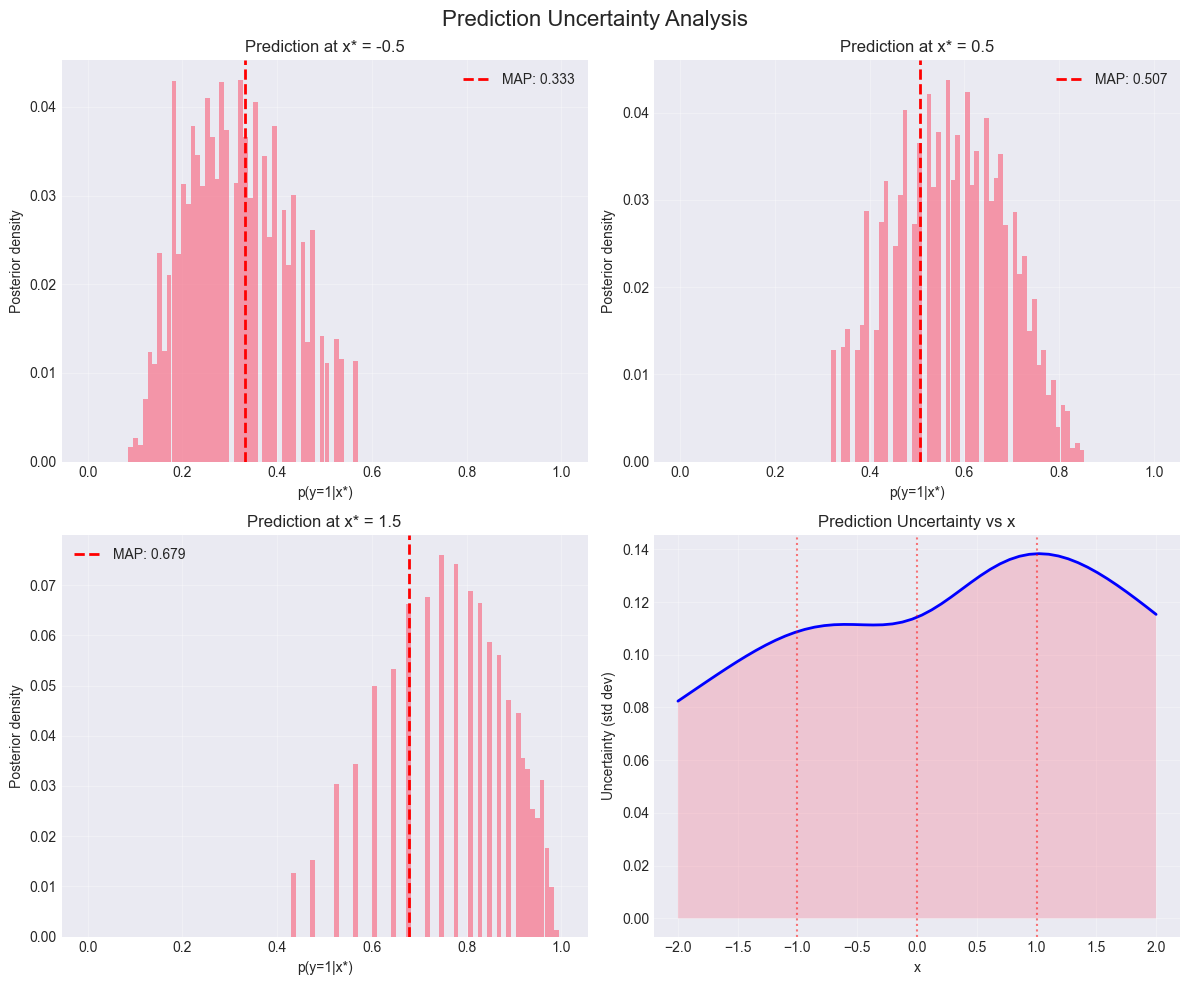

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, multivariate_normal
from scipy.special import expit  # This is the sigmoid function

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def sigmoid(z):
    """Logistic sigmoid function"""
    return 1 / (1 + np.exp(-z))

def visualize_logistic_hand_calculation():
    """
    Visual companion to the logistic regression hand calculation
    """
    
    # Data from hand calculation
    x_data = np.array([-1, 0, 1])
    y_data = np.array([0, 0, 1])
    
    # Prior parameters
    sigma2_alpha = 1.0
    sigma2_beta = 1.0
    
    # Create main figure
    fig = plt.figure(figsize=(15, 12))
    
    # 1. Data visualization
    ax1 = plt.subplot(3, 3, 1)
    plot_data_and_true_function(ax1, x_data, y_data)
    
    # 2. Prior distribution
    ax2 = plt.subplot(3, 3, 2)
    plot_prior_distribution(ax2, sigma2_alpha, sigma2_beta)
    
    # 3. Likelihood for each data point
    ax3 = plt.subplot(3, 3, 3)
    plot_individual_likelihoods(ax3, x_data, y_data)
    
    # 4. Grid approximation
    ax4 = plt.subplot(3, 3, 4)
    grid_values = plot_grid_approximation(ax4, x_data, y_data, 
                                         sigma2_alpha, sigma2_beta)
    
    # 5. Posterior distribution
    ax5 = plt.subplot(3, 3, 5)
    plot_posterior_distribution(ax5, grid_values)
    
    # 6. MAP estimate and predictions
    ax6 = plt.subplot(3, 3, 6)
    plot_map_predictions(ax6, x_data, y_data, grid_values)
    
    # 7. Marginal effects
    ax7 = plt.subplot(3, 3, 7)
    plot_marginal_effects(ax7)
    
    # 8. Comparison of different parameter values
    ax8 = plt.subplot(3, 3, 8)
    plot_parameter_comparison(ax8, x_data, y_data)
    
    # 9. Calculation details
    ax9 = plt.subplot(3, 3, 9)
    show_calculation_details(ax9)
    
    plt.suptitle('Logistic Regression: Hand Calculation Visualization', 
                fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Additional detailed plots
    plot_detailed_grid_calculation()
    plot_prediction_uncertainty()


def plot_data_and_true_function(ax, x_data, y_data):
    """Plot the data points and sigmoid curves"""
    x_range = np.linspace(-2, 2, 100)
    
    # Plot data
    ax.scatter(x_data[y_data == 0], y_data[y_data == 0], 
              s=200, c='red', marker='x', linewidth=3, label='y=0')
    ax.scatter(x_data[y_data == 1], y_data[y_data == 1], 
              s=200, c='blue', marker='o', label='y=1')
    
    # Plot some example sigmoid curves
    alphas = [-1, -0.5, 0]
    betas = [0.5, 1.5, 2.5]
    
    for i, (alpha, beta) in enumerate(zip(alphas, betas)):
        y_curve = sigmoid(alpha + beta * x_range)
        ax.plot(x_range, y_curve, alpha=0.7, linewidth=2,
               label=f'α={alpha}, β={beta}')
    
    ax.set_xlabel('x')
    ax.set_ylabel('p(y=1|x)')
    ax.set_title('Data and Example Sigmoid Curves')
    ax.set_ylim(-0.1, 1.1)
    ax.grid(True, alpha=0.3)
    ax.legend()


def plot_prior_distribution(ax, sigma2_alpha, sigma2_beta):
    """Plot the prior distribution p(α,β)"""
    alpha_range = np.linspace(-3, 3, 100)
    beta_range = np.linspace(-3, 3, 100)
    
    A, B = np.meshgrid(alpha_range, beta_range)
    
    # Prior is product of independent normals
    prior = norm.pdf(A, 0, np.sqrt(sigma2_alpha)) * \
            norm.pdf(B, 0, np.sqrt(sigma2_beta))
    
    contour = ax.contourf(A, B, prior, levels=20, cmap='Blues')
    ax.contour(A, B, prior, levels=10, colors='white', alpha=0.3, linewidths=0.5)
    
    ax.set_xlabel('α')
    ax.set_ylabel('β')
    ax.set_title('Prior Distribution p(α,β)')
    ax.grid(True, alpha=0.3)
    plt.colorbar(contour, ax=ax)


def plot_individual_likelihoods(ax, x_data, y_data):
    """Plot likelihood contribution from each data point"""
    colors = ['red', 'green', 'blue']
    
    for i, (x, y) in enumerate(zip(x_data, y_data)):
        x_range = np.linspace(-2, 2, 100)
        
        # For this data point, compute likelihood as function of x
        if y == 1:
            likelihood = sigmoid(x * x_range)
        else:
            likelihood = 1 - sigmoid(x * x_range)
        
        ax.plot(x_range, likelihood, color=colors[i], linewidth=2,
               label=f'Point {i+1}: x={x}, y={y}')
    
    ax.set_xlabel('Linear predictor (α + βx)')
    ax.set_ylabel('Likelihood')
    ax.set_title('Individual Point Likelihoods')
    ax.grid(True, alpha=0.3)
    ax.legend()


def plot_grid_approximation(ax, x_data, y_data, sigma2_alpha, sigma2_beta):
    """Plot the grid approximation calculation"""
    # Create grid
    alpha_grid = np.linspace(-1.5, 1, 6)
    beta_grid = np.linspace(-0.5, 2.5, 7)
    
    A, B = np.meshgrid(alpha_grid, beta_grid)
    
    # Calculate joint probability for each grid point
    joint_prob = np.zeros_like(A)
    
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            alpha = A[i, j]
            beta = B[i, j]
            
            # Likelihood
            likelihood = 1.0
            for x, y in zip(x_data, y_data):
                p = sigmoid(alpha + beta * x)
                if y == 1:
                    likelihood *= p
                else:
                    likelihood *= (1 - p)
            
            # Prior
            prior = norm.pdf(alpha, 0, np.sqrt(sigma2_alpha)) * \
                   norm.pdf(beta, 0, np.sqrt(sigma2_beta))
            
            # Joint
            joint_prob[i, j] = likelihood * prior
    
    # Plot
    im = ax.imshow(joint_prob, extent=[alpha_grid[0], alpha_grid[-1],
                                      beta_grid[0], beta_grid[-1]],
                   aspect='auto', origin='lower', cmap='hot')
    ax.set_xlabel('α')
    ax.set_ylabel('β')
    ax.set_title('Grid Approximation: p(y|α,β)p(α,β)')
    ax.grid(True, alpha=0.3)
    plt.colorbar(im, ax=ax)
    
    # Mark MAP estimate
    i_max, j_max = np.unravel_index(np.argmax(joint_prob), joint_prob.shape)
    ax.plot(alpha_grid[j_max], beta_grid[i_max], 'w*', markersize=15)
    
    return {'alpha_grid': alpha_grid, 'beta_grid': beta_grid, 
            'joint_prob': joint_prob}


def plot_posterior_distribution(ax, grid_values):
    """Plot the normalized posterior distribution"""
    # Normalize to get posterior
    posterior = grid_values['joint_prob'] / grid_values['joint_prob'].sum()
    
    alpha_grid = grid_values['alpha_grid']
    beta_grid = grid_values['beta_grid']
    
    contour = ax.contourf(alpha_grid, beta_grid, posterior, 
                         levels=20, cmap='viridis')
    ax.contour(alpha_grid, beta_grid, posterior, 
              levels=10, colors='white', alpha=0.3, linewidths=0.5)
    
    # Mark MAP
    i_max, j_max = np.unravel_index(np.argmax(posterior), posterior.shape)
    alpha_map = alpha_grid[j_max]
    beta_map = beta_grid[i_max]
    ax.plot(alpha_map, beta_map, 'r*', markersize=15, 
           label=f'MAP: α={alpha_map:.2f}, β={beta_map:.2f}')
    
    ax.set_xlabel('α')
    ax.set_ylabel('β')
    ax.set_title('Posterior Distribution p(α,β|y)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.colorbar(contour, ax=ax)


def plot_map_predictions(ax, x_data, y_data, grid_values):
    """Plot predictions using MAP estimate"""
    # Find MAP
    joint_prob = grid_values['joint_prob']
    i_max, j_max = np.unravel_index(np.argmax(joint_prob), joint_prob.shape)
    alpha_map = grid_values['alpha_grid'][j_max]
    beta_map = grid_values['beta_grid'][i_max]
    
    # Plot predictions
    x_range = np.linspace(-2, 2, 100)
    y_pred = sigmoid(alpha_map + beta_map * x_range)
    
    ax.plot(x_range, y_pred, 'g-', linewidth=3, 
           label=f'MAP: p(y=1|x) = σ({alpha_map:.2f} + {beta_map:.2f}x)')
    
    # Add data points
    ax.scatter(x_data[y_data == 0], y_data[y_data == 0], 
              s=200, c='red', marker='x', linewidth=3, zorder=3)
    ax.scatter(x_data[y_data == 1], y_data[y_data == 1], 
              s=200, c='blue', marker='o', zorder=3)
    
    # Prediction at x* = 0.5
    x_star = 0.5
    y_star = sigmoid(alpha_map + beta_map * x_star)
    ax.plot([x_star], [y_star], 'mo', markersize=12, 
           label=f'Prediction at x={x_star}: {y_star:.3f}')
    
    ax.set_xlabel('x')
    ax.set_ylabel('p(y=1|x)')
    ax.set_title('MAP Predictions')
    ax.set_ylim(-0.1, 1.1)
    ax.legend()
    ax.grid(True, alpha=0.3)


def plot_marginal_effects(ax):
    """Plot marginal effects ∂p/∂x"""
    alpha = -0.5
    beta = 2.0
    
    x_range = np.linspace(-2, 2, 100)
    p = sigmoid(alpha + beta * x_range)
    marginal_effect = beta * p * (1 - p)
    
    ax.plot(x_range, marginal_effect, 'b-', linewidth=2)
    ax.fill_between(x_range, 0, marginal_effect, alpha=0.3)
    
    # Mark specific points
    x_points = [-1, 0, 0.5, 1]
    for x in x_points:
        p_x = sigmoid(alpha + beta * x)
        me_x = beta * p_x * (1 - p_x)
        ax.plot([x], [me_x], 'ro', markersize=8)
        ax.text(x, me_x + 0.05, f'{me_x:.3f}', ha='center', fontsize=10)
    
    ax.set_xlabel('x')
    ax.set_ylabel('∂p/∂x')
    ax.set_title(f'Marginal Effects (α={alpha}, β={beta})')
    ax.grid(True, alpha=0.3)


def plot_parameter_comparison(ax, x_data, y_data):
    """Compare different parameter values"""
    x_range = np.linspace(-2, 2, 100)
    
    parameter_sets = [
        (-1.0, -1.0, 'Poor fit 1'),
        (-0.5, 1.5, 'Our estimate'),
        (0.0, 2.0, 'Good fit'),
        (0.5, 3.0, 'Too steep')
    ]
    
    for alpha, beta, label in parameter_sets:
        y_curve = sigmoid(alpha + beta * x_range)
        ax.plot(x_range, y_curve, linewidth=2, label=label)
    
    # Add data points
    ax.scatter(x_data[y_data == 0], y_data[y_data == 0], 
              s=150, c='red', marker='x', linewidth=3, zorder=3)
    ax.scatter(x_data[y_data == 1], y_data[y_data == 1], 
              s=150, c='blue', marker='o', zorder=3)
    
    ax.set_xlabel('x')
    ax.set_ylabel('p(y=1|x)')
    ax.set_title('Comparison of Different Parameters')
    ax.set_ylim(-0.1, 1.1)
    ax.legend()
    ax.grid(True, alpha=0.3)


def show_calculation_details(ax):
    """Show key hand calculations"""
    ax.axis('off')
    
    text = """
Hand Calculation Summary:

1. Data:
   (x₁, y₁) = (-1, 0)
   (x₂, y₂) = (0, 0)
   (x₃, y₃) = (1, 1)

2. Example calculation for α=-0.5, β=1.5:

   Point 1: z₁ = -0.5 + 1.5×(-1) = -2
           σ(-2) = 0.119
           p(y₁=0) = 0.881
   
   Point 2: z₂ = -0.5 + 1.5×0 = -0.5
           σ(-0.5) = 0.378
           p(y₂=0) = 0.622
   
   Point 3: z₃ = -0.5 + 1.5×1 = 1
           σ(1) = 0.731
           p(y₃=1) = 0.731
   
   Likelihood = 0.881 × 0.622 × 0.731 = 0.401

3. Prior:
   p(α=-0.5) = 0.352
   p(β=1.5) = 0.130
   p(α,β) = 0.046

4. Joint = 0.401 × 0.046 = 0.0185
"""
    
    ax.text(0.05, 0.95, text, transform=ax.transAxes, 
           fontsize=10, verticalalignment='top',
           fontfamily='monospace',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))


def plot_detailed_grid_calculation():
    """Show detailed grid calculation"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Data
    x_data = np.array([-1, 0, 1])
    y_data = np.array([0, 0, 1])
    
    # Small grid for detailed calculation
    alphas = np.array([-1.0, -0.5, 0.0])
    betas = np.array([0.0, 1.0, 2.0])
    
    # Calculate each component
    for idx in range(6):
        ax = axes[idx // 3, idx % 3]
        
        if idx < 3:
            # Likelihood for each parameter combination
            i = idx
            likelihood_grid = np.zeros((3, 3))
            
            for j, alpha in enumerate(alphas):
                for k, beta in enumerate(betas):
                    p = sigmoid(alpha + beta * x_data[i])
                    if y_data[i] == 1:
                        likelihood_grid[j, k] = p
                    else:
                        likelihood_grid[j, k] = 1 - p
            
            im = ax.imshow(likelihood_grid, cmap='YlOrRd', aspect='auto')
            ax.set_title(f'Likelihood: Point {i+1} (x={x_data[i]}, y={y_data[i]})')
            
            # Add text values
            for j in range(3):
                for k in range(3):
                    ax.text(k, j, f'{likelihood_grid[j, k]:.3f}', 
                           ha='center', va='center')
            
            ax.set_xticks([0, 1, 2])
            ax.set_yticks([0, 1, 2])
            ax.set_xticklabels(betas)
            ax.set_yticklabels(alphas)
            ax.set_xlabel('β')
            ax.set_ylabel('α')
            plt.colorbar(im, ax=ax)
        
        elif idx == 3:
            # Prior
            prior_grid = np.zeros((3, 3))
            for j, alpha in enumerate(alphas):
                for k, beta in enumerate(betas):
                    prior_grid[j, k] = norm.pdf(alpha, 0, 1) * norm.pdf(beta, 0, 1)
            
            im = ax.imshow(prior_grid, cmap='Blues', aspect='auto')
            ax.set_title('Prior p(α,β)')
            
            for j in range(3):
                for k in range(3):
                    ax.text(k, j, f'{prior_grid[j, k]:.3f}', 
                           ha='center', va='center')
            
            ax.set_xticks([0, 1, 2])
            ax.set_yticks([0, 1, 2])
            ax.set_xticklabels(betas)
            ax.set_yticklabels(alphas)
            ax.set_xlabel('β')
            ax.set_ylabel('α')
            plt.colorbar(im, ax=ax)
        
        elif idx == 4:
            # Total likelihood
            total_likelihood = np.ones((3, 3))
            for i in range(3):
                for j, alpha in enumerate(alphas):
                    for k, beta in enumerate(betas):
                        p = sigmoid(alpha + beta * x_data[i])
                        if y_data[i] == 1:
                            total_likelihood[j, k] *= p
                        else:
                            total_likelihood[j, k] *= (1 - p)
            
            im = ax.imshow(total_likelihood, cmap='Greens', aspect='auto')
            ax.set_title('Total Likelihood')
            
            for j in range(3):
                for k in range(3):
                    ax.text(k, j, f'{total_likelihood[j, k]:.3f}', 
                           ha='center', va='center')
            
            ax.set_xticks([0, 1, 2])
            ax.set_yticks([0, 1, 2])
            ax.set_xticklabels(betas)
            ax.set_yticklabels(alphas)
            ax.set_xlabel('β')
            ax.set_ylabel('α')
            plt.colorbar(im, ax=ax)
        
        else:
            # Joint and posterior
            joint_grid = total_likelihood * prior_grid
            posterior_grid = joint_grid / joint_grid.sum()
            
            im = ax.imshow(posterior_grid, cmap='viridis', aspect='auto')
            ax.set_title('Posterior p(α,β|y)')
            
            for j in range(3):
                for k in range(3):
                    ax.text(k, j, f'{posterior_grid[j, k]:.3f}', 
                           ha='center', va='center', 
                           color='white' if posterior_grid[j, k] > 0.2 else 'black')
            
            ax.set_xticks([0, 1, 2])
            ax.set_yticks([0, 1, 2])
            ax.set_xticklabels(betas)
            ax.set_yticklabels(alphas)
            ax.set_xlabel('β')
            ax.set_ylabel('α')
            plt.colorbar(im, ax=ax)
    
    plt.suptitle('Detailed Grid Calculation', fontsize=16)
    plt.tight_layout()
    plt.show()


def plot_prediction_uncertainty():
    """Show prediction uncertainty"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Data
    x_data = np.array([-1, 0, 1])
    y_data = np.array([0, 0, 1])
    
    # Grid values (simplified)
    alpha_grid = np.linspace(-1, 0.5, 10)
    beta_grid = np.linspace(0.5, 2.5, 10)
    
    # Calculate posterior (simplified)
    A, B = np.meshgrid(alpha_grid, beta_grid)
    posterior = np.zeros_like(A)
    
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            alpha = A[i, j]
            beta = B[i, j]
            
            # Likelihood
            likelihood = 1.0
            for x, y in zip(x_data, y_data):
                p = sigmoid(alpha + beta * x)
                if y == 1:
                    likelihood *= p
                else:
                    likelihood *= (1 - p)
            
            # Prior
            prior = norm.pdf(alpha, 0, 1) * norm.pdf(beta, 0, 1)
            
            # Posterior (unnormalized)
            posterior[i, j] = likelihood * prior
    
    # Normalize
    posterior /= posterior.sum()
    
    # Prediction points
    x_pred_points = [-0.5, 0.5, 1.5]
    
    for idx, x_pred in enumerate(x_pred_points):
        ax = axes[idx // 2, idx % 2]
        
        # Calculate prediction distribution
        p_pred = np.zeros(100)
        p_values = np.linspace(0, 1, 100)
        
        for i in range(A.shape[0]):
            for j in range(A.shape[1]):
                alpha = A[i, j]
                beta = B[i, j]
                p_mean = sigmoid(alpha + beta * x_pred)
                
                # Add to histogram (simplified - using delta functions)
                closest_idx = np.argmin(np.abs(p_values - p_mean))
                p_pred[closest_idx] += posterior[i, j]
        
        # Plot prediction distribution
        ax.bar(p_values, p_pred, width=0.01, alpha=0.7)
        ax.set_xlabel('p(y=1|x*)')
        ax.set_ylabel('Posterior density')
        ax.set_title(f'Prediction at x* = {x_pred}')
        ax.grid(True, alpha=0.3)
        
        # Add MAP prediction
        i_max, j_max = np.unravel_index(np.argmax(posterior), posterior.shape)
        alpha_map = alpha_grid[j_max]
        beta_map = beta_grid[i_max]
        p_map = sigmoid(alpha_map + beta_map * x_pred)
        ax.axvline(p_map, color='red', linestyle='--', linewidth=2,
                  label=f'MAP: {p_map:.3f}')
        ax.legend()
    
    # Last plot: show uncertainty vs x
    ax = axes[1, 1]
    x_range = np.linspace(-2, 2, 50)
    uncertainty = np.zeros_like(x_range)
    
    for idx, x in enumerate(x_range):
        p_values = []
        for i in range(A.shape[0]):
            for j in range(A.shape[1]):
                alpha = A[i, j]
                beta = B[i, j]
                p = sigmoid(alpha + beta * x)
                p_values.append(p)
        
        # Uncertainty as standard deviation
        uncertainty[idx] = np.std(p_values)
    
    ax.plot(x_range, uncertainty, 'b-', linewidth=2)
    ax.fill_between(x_range, 0, uncertainty, alpha=0.3)
    ax.set_xlabel('x')
    ax.set_ylabel('Uncertainty (std dev)')
    ax.set_title('Prediction Uncertainty vs x')
    ax.grid(True, alpha=0.3)
    
    # Mark data points
    for x in x_data:
        ax.axvline(x, color='red', linestyle=':', alpha=0.5)
    
    plt.suptitle('Prediction Uncertainty Analysis', fontsize=16)
    plt.tight_layout()
    plt.show()


# Run the visualization
if __name__ == "__main__":
    print("Logistic Regression: Hand Calculation Visualization")
    print("=" * 50)
    visualize_logistic_hand_calculation()